In [1]:
import numpy as np
import torch
from diffusion import *
from torch.optim import Adam
import bgflow.distribution.sampling.mcmc as MCMC
import bgflow.distribution.energy.double_well as DoubleWell
import bgflow.distribution.normal as Normal
from diffusion.potential import LinearInterpolation 
from diffusion.utils import load_or_generate_and_then_save
import matplotlib.pyplot as plt

torch.random.manual_seed(199)

device = 'cuda'

In [2]:
# prepare a grid for plotting
ts = torch.linspace(0, 1, 50, dtype=torch.float32, device=device)
xs = torch.linspace(-3, 3, 50, dtype=torch.float32, device=device)

X, Y = torch.meshgrid(xs, ts, indexing='ij')


In [3]:
target = DoubleWell.DoubleWellEnergy(dim=1, b=-4., c=1.)
prior = Normal.NormalDistribution(dim=1)

net = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.SiLU(), torch.nn.Linear(64, 1)).to(device)

In [4]:
# the potential function
V = LinearInterpolation(prior, target, net)

In [44]:
naive_interpolation = lambda x, t :  (1-t) * target.energy(x) + (t) * prior.energy(x)

def to_normalized_probabilities(energies):
    probabilities = torch.exp(-energies)
    probabilities = probabilities - probabilities.min(dim=0, keepdim=True)[0]
    probabilities = probabilities / probabilities.sum(dim=0, keepdim=True)
    return probabilities

def compute_energies_naive(xs, ts):
    naive_out = naive_interpolation(xs, ts)
    return naive_out

def compute_probabilities_naive(xs, ts):
    naive_out = compute_energies_naive(xs, ts)
    return to_normalized_probabilities(naive_out)
 
def compute_forces_naive(xs, ts):
    xs_copy = xs.clone()
    xs_copy.requires_grad_(True)
    energies = compute_energies_naive(xs_copy, ts).sum()
    naive_forces = -torch.autograd.grad(energies, xs_copy)[0]
    return naive_forces

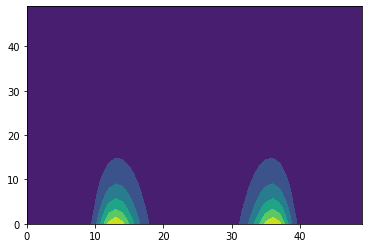

In [49]:
plt.contourf(compute_probabilities_naive(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).cpu())

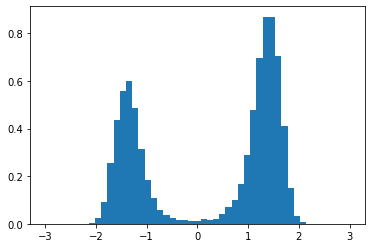

In [6]:
sampler = MCMC.GaussianMCMCSampler(energy=target, init_state=torch.tensor([0.]))


datafilepath = './data/double_well.npy'
data = torch.from_numpy(load_or_generate_and_then_save(datafilepath, lambda : sampler.sample(n_samples=50000)))

# plot histogram of the sampled data
counts, bins = np.histogram(data, bins=xs.cpu(), density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()


In [7]:
def cumulative_beta_linear(t):
    '''The integral of the noise schedule over the interval [0, t]. In this case a simple linear schedule'''
    return t

sde = SDE(TransitionKernel(cumulative_beta=cumulative_beta_linear))

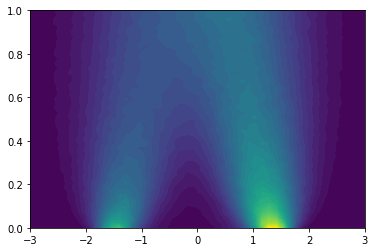

In [8]:
# Show diffusion distribution of the data when propagating using the SDE
z = torch.zeros_like(X)
for i, t in enumerate(ts):
    t_s=torch.full_like(data, t)
    x_t = sde.forward_sample(x_0=data, t=t_s)
    z[:, i] = torch.histogram(x_t, bins=torch.cat([xs.cpu(), torch.tensor([6.])]))[0]


plt.contourf(X.cpu(), Y.cpu(), z.cpu(), levels=50)

In [9]:
batch_size = 128

diff_model = DiffusionModel(potential=V, device=device)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
optimizer = Adam(diff_model.parameters(), lr=1e-2)


def MSE_loss(prediction, ground_truth):
    loss = ((prediction - ground_truth)**2).mean()
    return loss


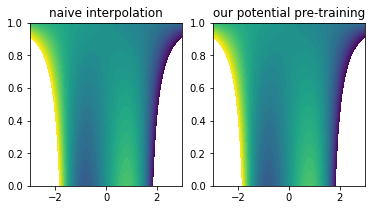

In [10]:
pre_training_out = diff_model(X.reshape(50*50, 1).clone(), Y.reshape(50*50, 1).clone())[0].view(50,50).detach()
#pre_training_out = to_normalized_probabilities(pre_training_out)

naive_forces = compute_forces_naive(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50, 50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.set_title('naive interpolation')
ax1.contourf(X.cpu(), Y.cpu(), naive_forces.cpu(), levels=np.linspace(-10,10,50))
ax2.set_title('our potential pre-training')
ax2.contourf(X.cpu(), Y.cpu(), pre_training_out.cpu(), levels=np.linspace(-10,10,50))

plt.show()

In [11]:
from diffusion.train import train

train(diff_model, 
      sde=sde,
      loss_fn=MSE_loss, 
      optimizer=optimizer, 
      data_loader=train_loader, 
      n_iterations=10, 
      device=device)

Epoch 0/10 total loss: 1355501.875324218758755
Epoch 1/10 total loss: 1270515.0.4189453125875
Epoch 2/10 total loss: 1329427.125243652343755
Epoch 3/10 total loss: 1411807.625296142578125
Epoch 4/10 total loss: 1314238.375919921875255
Epoch 5/10 total loss: 1333822.625428955078125
Epoch 6/10 total loss: 1380124.251809082031255
Epoch 7/10 total loss: 1310475.0.8674316406255
Epoch 8/10 total loss: 1270099.5.6489257812555
Epoch 9/10 total loss: 1330176.0.4819335937555


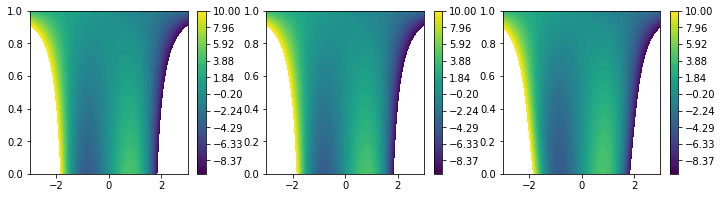

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

post_training_out = diff_model(X.reshape(50*50, 1), Y.reshape(50*50, 1))[0].view(50,50).detach()

im1 = ax1.contourf(X.cpu(), Y.cpu(), naive_forces.cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im1, ax=ax1)
im2 = ax2.contourf(X.cpu(), Y.cpu(), pre_training_out.cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im2, ax=ax2)
im3 = ax3.contourf(X.cpu(), Y.cpu(), post_training_out.cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im3, ax=ax3)

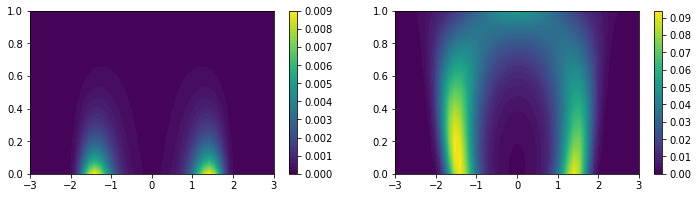

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

post_training_energy = V(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).detach()
post_training_probability = to_normalized_probabilities(post_training_energy)
naive_probabilities = compute_probabilities_naive(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).cpu()

im1 = ax1.contourf(X.cpu(), Y.cpu(), naive_probabilities, levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im1, ax=ax1)
im2 = ax2.contourf(X.cpu(), Y.cpu(), post_training_probability.cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im2, ax=ax2)

In [39]:
from math import sqrt


def langevin(force: callable, x_0: torch.tensor, tau: torch.FloatType):
    '''Do langevin dynamics of the potential from x_0 at t=1 to x_t at t=0 with timestep tau.
    (actually, start at t=1e-5 for stability reasons)'''
    t = 1
    x_t = x_0
    sqrt_tau = sqrt(tau)
    while t > 1e-5:
        t_s = torch.full_like(x_t, t)
        # x_t = x_t + tau * 0.5 * force.energy(x_t) + sqrt_tau * torch.rand_like(x_t)
        x_t = x_t + tau * 0.5 * force(x_t, t_s) + sqrt_tau * torch.randn_like(x_t)
        t -= tau
    return x_t


x_0 = torch.randn((10000, 1)).to(device)
x_t = langevin(lambda x, t: diff_model(x, t)[0], x_0, 0.001)

#x_t = langevin(lambda x, t: compute_forces_naive(x, t), x_0, 0.001)

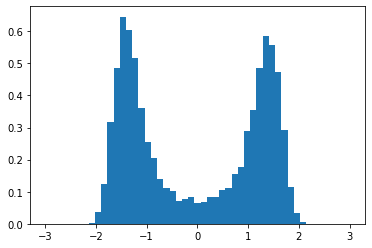

In [40]:
# plot histogram of the sampled data
counts, bins = np.histogram(x_t.detach().cpu(), bins=xs.cpu(), density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()
